<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Lesson_6_Rossmann_fast.ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 6: Regularization; Convolutions; Data ethics

https://course.fast.ai/videos/?lesson=6

https://github.com/hiromis/notes/blob/master/Lesson6.md


Today we discuss some powerful techniques for improving training and avoiding over-fitting:

* Dropout: remove activations at random during training in order to regularize the model
* Data augmentation: modify model inputs during training in order to effectively increase data size
* Batch normalization: adjust the parameterization of a model in order to make the loss surface smoother.

Next up, we'll learn all about convolutions, which can be thought of as a variant of matrix multiplication with tied weights, and are the operation at the heart of modern computer vision models (and, increasingly, other types of models too).

We'll use this knowledge to create a class activated map, which is a heat-map that shows which parts of an image were most important in making a prediction.

Finally, we'll cover a topic that many students have told us is the most interesting and surprising part of the course: data ethics. We'll learn about some of the ways in which models can go wrong, with a particular focus on feedback loops, why they cause problems, and how to avoid them. We'll also look at ways in which bias in data can lead to biased algorithms, and discuss questions that data scientists can and should be asking to help ensure that their work doesn't lead to unexpected negative outcomes.

Data & Feature  [Notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/rossman_data_clean.ipynb)

Model [Notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-rossmann.ipynb)

# Notes

RNN tends to performs well perhaps on acadmic data without complex entity relationships.

Recognizing cyclic or seasonal data requires "date" to be in category formal. For equity trading, however, you may need to do more than just that. 

Sales is the depnding variable with the rest being features required to predict sales.

Procs: 
* Runs once on the train set and all resulting meta-date is shared with test & validation 

data.export 
* saves the entire databunch 

Need to seperate categorial and continous data.

categorial
* May exposes implicit values through embedding matrix
* If in doubt, try it out

LabelClass: FloatList 
* Must be Float for regression 
* set to FloatList to tunr the learner into a regressor  


log = true 
* logarithm of y 
* when RMSPE error function 
* when you take the log of RSME, it becomes the RMSPE 
* long tail distributions require percentage change differences, this RMSPE needs to be measured 
* Set log range of y a bit wider 

Model architecture 
* Most basic NN FCN
* interemediate weighmtraix (1000X500) - 500k a lot for just a hundred few features 
* Use regularization, weight decay, and dropout  to avoid overfitting
* Weight decay is already applied automocatlly by the fast.ai lib

Dropout: 
* kind of regularization 
* Randoomly drops activations  from the net
* Removes connection between nodes
* For each batch, we through away ~5% of activations and inputs 
* On the next batch, the previous drops are restored, and ot hers are dropped randoomly.
* No one activation can memorize the input
* Therefore, instead of memorizing one specific input (image), the net must learn to recognize features
* In practice, it works very well.
* Requires a bit of tweaking of the ps (p value of droput values) to figure out which one works best

Embedding dropout 
* Special dropout for embedding 
* Embedding is  a matrix multiply with aone-hot encoded
* Thus, randoom drops can be dine 
* Experiments showed that embeeding dropout increased acc. with low erreror variance

## Install 

In [0]:
!pip install imgaug==0.2.7

!pip install folium==0.2.1

!pip install --upgrade pandas

!pip install --upgrade numpy

!pip install isoweek

#!pip install --upgrade fastai

!curl -s https://course.fast.ai/setup/colab | bash

## Constants & global flags

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Import Fast.ai & PyTorch


In [3]:
import fastai
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.collab import *
from fastai.tabular import *

import matplotlib.pyplot as plt
from PIL import Image

print("FastAI Version: " + str(fastai.__version__))

FastAI Version: 1.0.51


In [4]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## Check GPU *acceleration*

In [5]:
torch.cuda.current_device()
print("Cuda available: " + str(torch.cuda.is_available()))
print("Cuda enabled:" + str(torch.backends.cudnn.enabled))
#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
#Additional Info when using cuda
if device.type == 'cuda':
    print("GPU used: " + torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Cuda available: True
Cuda enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Rossmann Data preparation / Feature engineering¶


In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them here. Then you shold untar them in the dirctory to which PATH is pointing below. For completeness, the implementation used to put them together is included below.

In [0]:
!mkdir data/rossmann/

In [7]:
!wget http://files.fast.ai/part2/lesson14/rossmann.tgz -P data/rossmann/

--2019-04-03 11:24:05--  http://files.fast.ai/part2/lesson14/rossmann.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7730448 (7.4M) [text/plain]
Saving to: ‘data/rossmann/rossmann.tgz’

rossmann.tgz        100%[===================>]   7.37M  28.9MB/s    in 0.3s    

2019-04-03 11:24:06 (28.9 MB/s) - ‘data/rossmann/rossmann.tgz’ saved [7730448/7730448]



In [8]:
! tar -xvzf data/rossmann/rossmann.tgz --directory data/rossmann/

googletrend.csv
sample_submission.csv
state_names.csv
store.csv
store_states.csv
test.csv
train.csv
weather.csv


In [17]:
PATH=Path('data/rossmann/')
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
tables = [pd.read_csv(PATH/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. 
We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [0]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

join_df is a function for joining tables on specific fields. By default, we'll be doing a left outer join of right on the left argument using the given fields for each table.

Pandas does joins using the merge method. The suffixes argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "_y" to those on the right.

In [0]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [19]:
weather.head(3)

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240


In [16]:
state_names.head(3)

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE


In [0]:
# Join weather/state names.
# doing a left outer join of right on the left argument using the given fields for each table.
# file refers to StateName in weather table 
# StateName referes to StateName in the StateName table.
# that way, different names for the same key get matched correctly .
# then, the State table is appened to the roght on the weather table. 
weather = join_df(weather, state_names, "file", "StateName")

In [0]:
weather.head()

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use .loc[rows, cols] to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list googletrend.State=='NI' and selecting "State".

In [0]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [0]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
# categorify date 
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.



In [0]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

Aside: Why note just do an inner join? If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [33]:
store = join_df(store, store_states, "Store") # join over store"
len(store[store.State.isnull()]) # Null check

0

In [34]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()]) # Null check

(0, 0)

In [35]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()]) 

(0, 0)

In [36]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [41]:
joined.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day_DE,Dayofweek_DE,Dayofyear_DE,Is_month_end_DE,Is_month_start_DE,Is_quarter_end_DE,Is_quarter_start_DE,Is_year_end_DE,Is_year_start_DE,Elapsed_DE
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600


In [42]:
weather.head(1)

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,1,1,1,False,True,False,True,False,True,1356998400


In [0]:
weather = join_df(weather, state_names, "file", "StateName")


In [47]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [0]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with NA's. NA (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary signal value that doesn't otherwise appear in the data.

In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)
    

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of apply() in mapping a function across dataframe values.



In [0]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [0]:
# We'll replace some erroneous / outlying data.
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.



In [52]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates. You may need to install the isoweek package first.



In [0]:
from isoweek import Week
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [0]:
joined.to_pickle(PATH/'joined')
joined_test.to_pickle(PATH/'joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:

* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function get_elapsed for cumulative counting across a sorted dataframe. Given a particular field fld to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.



In [0]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []
    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We'll be applying this to a subset of columns:



In [0]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:
#df = train[columns]
df = train[columns].append(test[columns])

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call add_elapsed('SchoolHoliday', 'After'): This will apply to each row with School Holiday:

A applied to every row of the dataframe in order of store and date
Will add to the dataframe the days since seeing a School Holiday
If we sort in the other direction, this will count the days until another holiday.

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [67]:
df.head(1)

,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-09-17,1,1,False,0,13.0,NaN,105.0,NaN,0.0,0.0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1058297 entries, 2015-09-17 to 2013-01-01
Data columns (total 10 columns):
Store                  1058297 non-null int64
Promo                  1058297 non-null int64
StateHoliday           1058297 non-null bool
SchoolHoliday          1058297 non-null int64
AfterSchoolHoliday     1058297 non-null float64
BeforeSchoolHoliday    1041515 non-null float64
AfterStateHoliday      1058211 non-null float64
BeforeStateHoliday     963124 non-null float64
AfterPromo             1051608 non-null float64
BeforePromo            1058297 non-null float64
dtypes: bool(1), float64(6), int64(3)
memory usage: 81.8 MB


In [0]:
# We're going to set the active index to Date.#
# df = df.set_index("Date")

In [0]:
# Then set null values from elapsed field calculations to 0.
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)


Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (sort_index()) and counting the number of events of interest (sum()) defined in columns in the following week (rolling()), grouped by Store (groupby()). We do the same in the opposite direction.

In [0]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [0]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.



In [0]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [79]:
df.head(1)


,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,1,False,0,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0


In [80]:
# remove the arbitrary index added before
df.drop(columns,1,inplace=True)
df.head(1)

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0


It's usually a good to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.



In [0]:
df.to_pickle(PATH/'df')

In [0]:
# convert date to datetime , required for the next next merge 
df["Date"] = pd.to_datetime(df.Date)


In [83]:
df.columns


Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [0]:
# load the previously merged table
joined = pd.read_pickle(PATH/'joined')
joined_test = pd.read_pickle(PATH/f'joined_test')

In [0]:
# merge train with df / elapsed 
joined = join_df(joined, df, ['Store', 'Date'])

In [0]:
# merge test with df/elapsed
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [0]:
joined = joined[joined.Sales!=0]

We'll back this up as well.



In [0]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [0]:
joined.to_pickle(PATH/'train_clean')
joined_test.to_pickle(PATH/'test_clean')

# Rossmann model & prediction

In [0]:
path = Config().data_path()/'rossmann'

train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [0]:
# train_df.head(1).T
# quite a long table to show ....

In [95]:
len(train_df),len(test_df)

(844338, 41088)

In [0]:
procs=[FillMissing, Categorify, Normalize]


Split columns into categorial and continous 

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Prepare train set 

In [102]:
dep_var = 'Sales'
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [99]:
# check test date range
test_df['Date'].min(), test_df['Date'].max()


(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [100]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

Create data bunch for the model

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

## Model

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [0]:
learn.model


In [107]:
len(data.train_ds.cont_names)


16

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


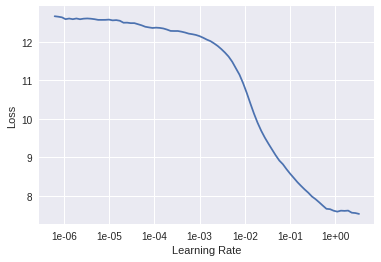

In [108]:
learn.lr_find()
learn.recorder.plot()


In [109]:
ep = 5 # eopchs 
lr = 1e-3 # lr, beggining of down-turn X 10 
wd=0.2 # weight decay 
learn.fit_one_cycle(ep,lr, wd)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.023161,0.022537,0.149404,04:48
1,0.016105,0.016014,0.129054,04:44
2,0.018887,0.158742,0.121515,04:43
3,0.014890,0.071742,0.115607,04:53
4,0.010385,0.038330,0.112735,04:43


In [0]:
# save initial model
learn.save('1')

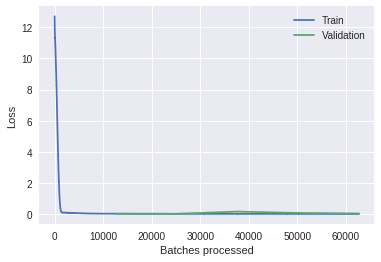

In [113]:
learn.recorder.plot_losses()

## Train & Tweak model

In [0]:
# load previous model 
learn.load('1');

In [115]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012324,0.013265,0.108507,05:03
1,0.011048,0.062358,0.113514,04:56
2,0.011140,0.017969,0.119366,04:56
3,0.009989,0.014190,0.108172,04:57
4,0.009558,0.053943,0.110374,04:58


(10th place in the competition was 0.108 exp_rmspe)


Get prdictions 

In [0]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)